# Statistical inference

## [Scientific Computing with Python](http://scicompy.yoavram.com)
## Yoav Ram

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.stats
import scipy.special as spec
import urllib.request
import os.path
import zipfile
import pandas as pd
import seaborn as sns
sns.set(
    style='white',
    context='talk'
)
red, blue, green = sns.color_palette('Set1', 3)

# Statistical inference: the frequentist approach

> Statistical inference makes propositions about a population, using data drawn from the population with some form of sampling. Given a hypothesis about a population, for which we wish to draw inferences, statistical inference consists of (first) selecting a statistical model of the process that generates the data and (second) deducing propositions from the model.

The two major approaches to statistical inference (and statistics as a whole) are the **frequentist** and **Bayesian** approaches.

Today we will deal with the frequentist approach.

# Simple model for photon counts

This example follows a [blog post by Jake VanDerPlas](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/).

Imagine that we point our telescope to the sky, and observe the light coming from a single star.

For the time being, we'll assume that the star's true flux is constant with time, i.e. that is it has a fixed value $\mu$ (we'll also ignore effects like sky noise and other sources of systematic error).
We'll assume that we perform a series of $n$ measurements with our telescope, where the $i^{\rm th}$ measurement reports the observed photon flux $X_i$, which is Poisson-distributed around $\mu$:
$$
X_i \sim Poi(\mu)
$$

The question is, given this set of measurements $\{X_i\}$, what is our best estimate of the true flux $\mu$?

We start by generating some data.

In [6]:
np.random.seed(1)

# true flux: number of photons measured in 1 second
μ = 1000  
# number of measurements
n = 50 
# n measurements of the flux
X = np.random.poisson(μ, size=n)

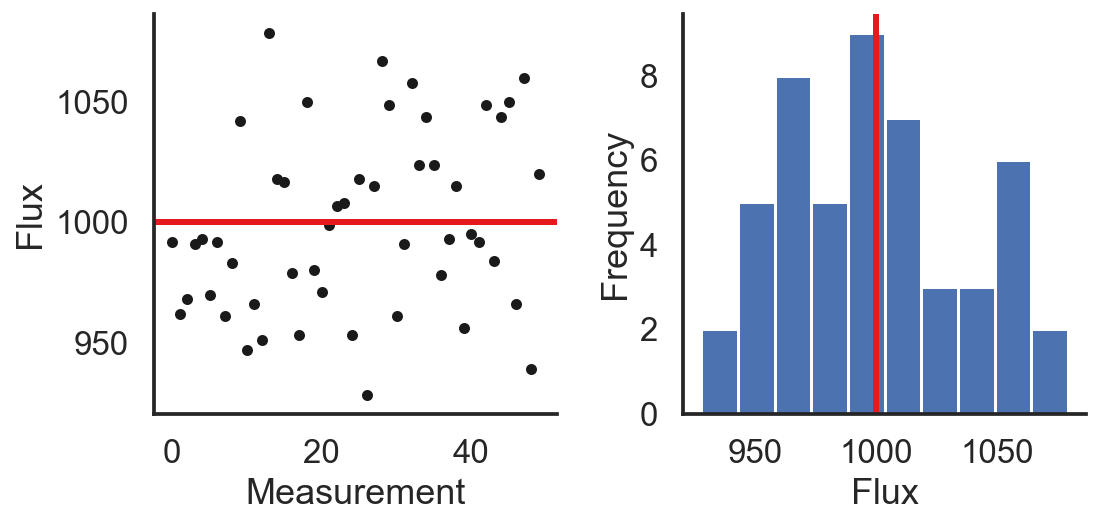

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

ax = axes[0]
ax.plot(np.arange(n), X, '.k')
ax.axhline(μ, linewidth=3, color=red)
ax.set_xlabel("Measurement")
ax.set_ylabel("Flux")

ax = axes[1]
ax.hist(X, bins=10)
ax.axvline(μ, linewidth=3, alpha=1, color=red)
ax.set_ylabel("Frequency")
ax.set_xlabel("Flux")

fig.tight_layout()
sns.despine()

In this toy example we already know the
true flux $\mu$, but the question is this: **given our measurements $\{X_i\}, what is our best estimate of the true flux $\mu$?**

## Maximum likelihood

Maximum likelihood is a very common and popular approach to statistical inference in which we look for the model that has the maximum probability to generate the observed data.

Formally, the **likelihood $\mathcal{L}$ of the model 
$$
X_i \sim Poi(\mu)
$$
given observed data $\{(X_i)\}_i$ is the probability of seeing data given the model:**
$$
\mathcal{L}(\mu~|~X) = 
\prod_{i=1}^n P(x_i~|~\mu)
$$

We assume (or even know) that the distribution of the measurements $\{X_i\}$ is Poisson.
Therefore, the probability that $X_i=k$ given $\mu$ is
$$
P(X_i=k~|~\mu) = 
\frac{\mu^{k} e^{-\mu}}{k!}
$$

So the likelihood $\mathcal{L}$ is a product of exponents.
Therefore, we take the log-likelihood $\log\mathcal{L}$:

$$
\log\mathcal{L}(\mu~|~X) = 
\sum_{i=1}^n \log{P(x_i~|~\mu)}
$$

In [12]:
def log_likelihood(μ, X):
    return scipy.stats.poisson(μ).logpmf(X).sum()

Here's a plot of the log-likelihood function, with the true value in red circle and the measured values in black dots.

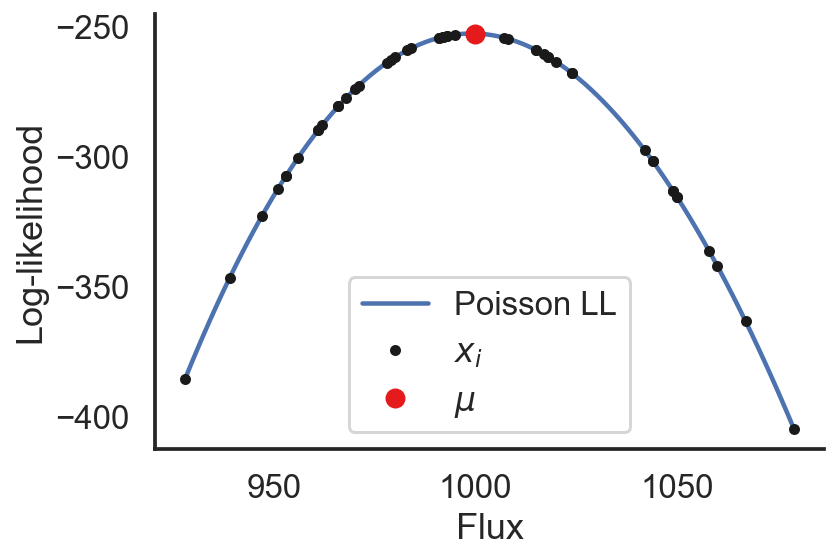

In [13]:
X_range = np.linspace(X.min(), X.max(),100)
plt.plot(X_range, [log_likelihood(x, X) for x in X_range], label='Poisson LL')
plt.plot(X, [log_likelihood(x, X) for x in X], '.k', label='$x_i$')
plt.plot(μ, log_likelihood(μ, X), 'o', color=red, label='$μ$')
plt.xlabel("Flux")
plt.ylabel("Log-likelihood")
plt.legend()
sns.despine()

WeThe flux value $\hat{\mu}$ that maximizes the log-likelihood $\log\mathcal{L}$ will be our **maximum likelihood estimate $\hat{\mu}$**.

We can find this analytically by solving for the root of the derivative of the normal approximation of the log-likelihood:

$$
\frac{d\log\mathcal{L}}{d\hat{\mu}}
\\ =
\frac{d}{d\hat{\mu}} \sum_{i=1}^n{\log{\frac{\hat{\mu}^{x_i} e^{-\hat{\mu}}}{x_i!}}}
\\ =
\frac{d}{d\hat{\mu}} \sum_{i=1}^n{\log{\hat{\mu}^{x_i}} + \log{e^{-\hat{\mu}}} - \log{(x_i!)}}
\\ =
\frac{d}{d\hat{\mu}} \sum_{i=1}^n{x_i \log{\hat{\mu}} -\hat{\mu} - \log{(x_i!)}}
\\ =
\sum_{i=1}^n{\frac{x_i}{\hat{\mu}} - 1}
\\ =
\frac{1}{\hat{\mu}} \sum_{i=1}^n{x_i} - n
$$

So
$$
\frac{d\log\mathcal{L}}{d\hat{\mu}} = 0 \Rightarrow
\hat{\mu} = \frac{1}{n}\sum_{i=1}^n{x_i}
$$
So the estimate $\hat{\mu}$ is the _arithmetic mean_!

μ = 1000 
μ_hat = 999.04


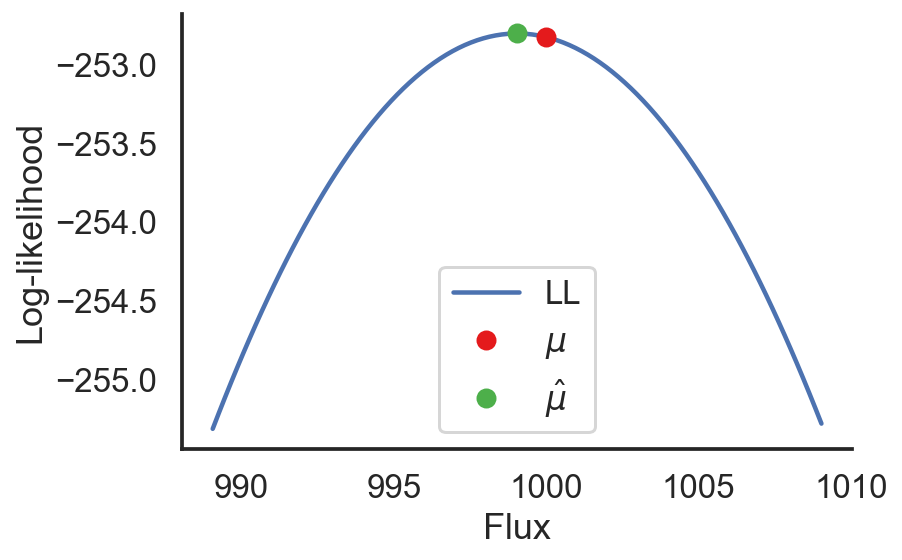

In [14]:
μ_hat = X.mean()
print("μ = {} \nμ_hat = {}".format(μ, μ_hat))

X_range = np.linspace(μ_hat*0.99, μ_hat*1.01, 100)
plt.plot(X_range, [log_likelihood(x, X) for x in X_range], label='LL')
plt.plot(μ, log_likelihood(μ, X), 'o', color=red, label='$μ$')
plt.plot(μ_hat, log_likelihood(μ_hat, X), 'o', color=green, label='$\hat{μ}$')

plt.xlabel("Flux")
plt.ylabel("Log-likelihood")
plt.legend()
sns.despine()

The [Cramér–Rao bound](https://en.wikipedia.org/wiki/Cramér–Rao_bound) provides a lower bound for the precision of this estimate

$$
var(\hat{\mu}) \ge \frac{1}{\mathcal{I}}
$$

where $\mathcal{I}$ is Fisher information, defined as:
$$
\mathcal{I} = - \mathbf{E}\Big[\frac{d^2\log\mathcal{L}}{d\hat{\mu}^2} \Big]
$$

So, we have
$$
\frac{d\log\mathcal{L}}{d\hat{\mu}} =
\frac{1}{\hat{\mu}} \sum_{i=1}^n{x_i} - n \Rightarrow \\
\frac{d^2\log\mathcal{L}}{d\hat{\mu}^2}  =
-\frac{1}{\hat{\mu}^2} \sum_{i=1}^n{x_i} \Rightarrow \\
\mathcal{I} =
- \mathbf{E}\Big[-\frac{1}{\hat{\mu}^2} \sum_{i=1}^n{x_i} \Big] = 
\frac{1}{\hat{\mu}^2} \mathbf{E}\Big[ \sum_{i=1}^n{x_i} \Big] =
\frac{n}{\hat{\mu}} 
\Rightarrow \\
var(\hat{\mu}) \ge
\frac{\hat{\mu}}{n}  \Rightarrow \\
\sigma_{\hat{\mu}} \ge
\sqrt{\frac{\hat{\mu}}{n}}
$$

μ = 1000 
μ_hat = 999.04 +/- 4.469988814303678


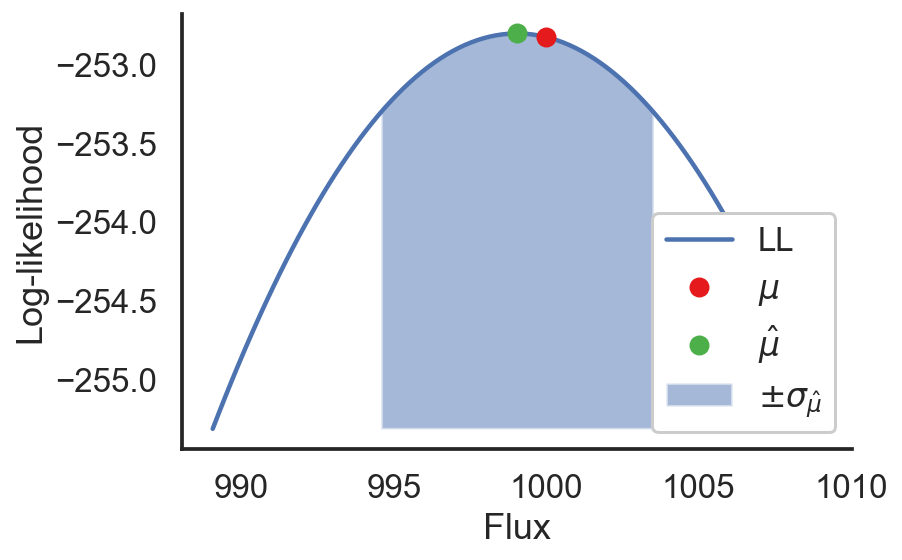

In [15]:
σ_hat = np.sqrt(μ_hat/n)
print("μ = {} \nμ_hat = {} +/- {}".format(
    μ, μ_hat, σ_hat))

X_range = np.linspace(μ_hat*0.99, μ_hat*1.01, 100)
plt.plot(X_range, [log_likelihood(x, X) for x in X_range], label='LL')
plt.plot(μ, log_likelihood(μ, X), 'o', color=red, label='$μ$')
plt.plot(μ_hat, log_likelihood(μ_hat, X), 'o', color=green, label='$\hat{μ}$')

X_range = np.linspace(μ_hat-σ_hat, μ_hat+σ_hat)
plt.fill_between(X_range, log_likelihood(μ_hat*0.99, X), 
                 [log_likelihood(x, X) for x in X_range], 
                 alpha=0.5, label='$\pm \sigma_{\hat{\mu}}$')
plt.xlabel("Flux")
plt.ylabel("Log-likelihood")
plt.legend(loc='lower right', framealpha=1)
sns.despine()

# Complex model for photon count

We now assume that the light source is dynamic and stochastic (e.g. Quasar).

That is, the measurements $\{X_i\}$ are still drawn from a Poisson distribution, but the expectation ($F$) changes over time -- it is drawn from a normal distrubtion with expectation $\mu$ and standard deviation $\sigma$:
$$
F_i \sim N(\mu, \sigma) \\
X_i \sim Poi(F)
$$

We note the model parameters as $\theta = (\mu, \sigma)$.

Let's generate data according to this model.

In [16]:
# for reproducibility
np.random.seed(42)
# we'll use more samples for the complex model
n = 100  
# parameters stochastic flux model
θ = (μ, σ) = 1000, 15
# (unknown) true flux
F = np.random.normal(μ, σ, size=n)
# observed flux: true flux plus Poisson errors
X = np.random.poisson(F)

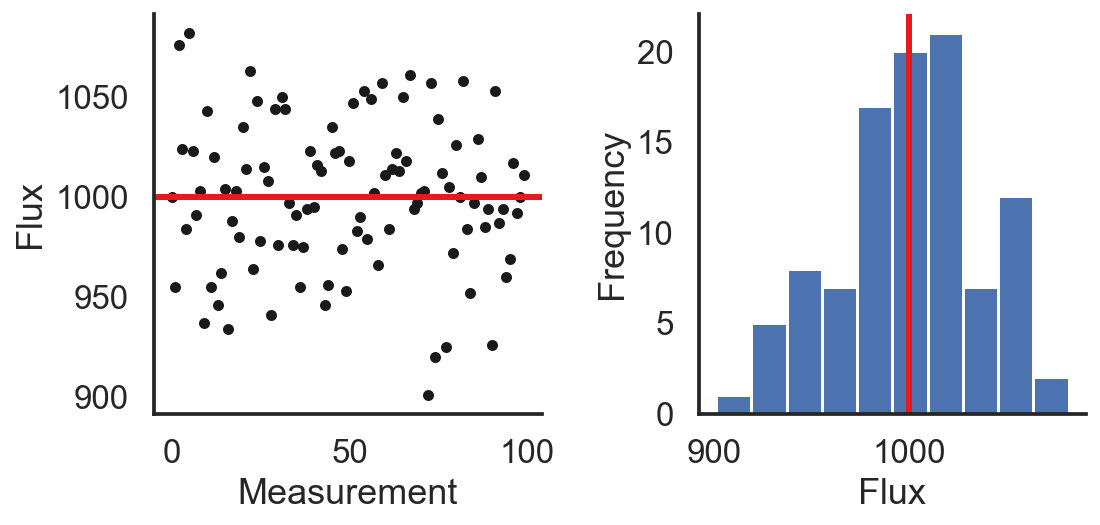

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

ax = axes[0]
ax.plot(np.arange(n), X, '.k')
ax.axhline(μ, linewidth=3, color=red)
ax.set_xlabel("Measurement")
ax.set_ylabel("Flux")

ax = axes[1]
ax.hist(X, bins=10)
ax.axvline(μ, linewidth=3, alpha=1, color=red)
ax.set_ylabel("Frequency")
ax.set_xlabel("Flux")

fig.tight_layout()
sns.despine()

Here we make use of the normal approximation of the Poisson distribution, which works well for high expected values, so that 
$$
F_i \sim N(\mu, \sigma^2) \\
X_i \sim Poi(F_i) \approx N(F_i, F_i^2)
$$

This is useful because compounding normal distributions gives a normal distribution with a sum of variances:

$$
X_i \approx N(\mu, \sigma^2 + e_i^2)
$$
where we estimate $e_i^2$ from the data as $X_i$.

The likelihood function is therefore

$$
\mathcal{L}(\mu, \sigma~|~X) = 
\prod_{i=1}^n \frac{1}{\sqrt{2\pi(\sigma^2 + X_i)}}\exp[\frac{-(X_i - \mu)^2}{2(\sigma^2 + X_i^2)}]
$$

To find an analytic solution to the maximum likelihood problem we differentiate and set to zero to get

$$
\hat{\mu} = \frac{\sum_{i=1}^n{\frac{X_i}{\sigma^2 + X_i}}}{\sum_{i=1}^n{\frac{1}{\sigma^2+X_i}}}.
$$

However, we see that the estimate for $\mu$ depends on $\sigma$ (and vice versa) so we cannot use a straightforward analytic method.

Instead, we will use a numerical optimization routine from `scipy.optimize`.

In [18]:
def log_likelihood(θ, X):
    μ, σ = θ
    return -0.5 * (np.log(2 * np.pi * (σ**2 + X)) + (X - μ) ** 2 / (σ**2 + X)).sum()
log_likelihood(θ, X)

-503.223428772118

Note that optimization routines usually _minimize_ rather than _maximize_, so we use the negative log-likelihood.

In [19]:
def neg_log_likelihood(θ, X):
    return -log_likelihood(θ, X)

neg_log_likelihood(θ, X)

503.223428772118

In [20]:
θ_guess = (900, 5)
θ_hat = scipy.optimize.fmin(
    func=neg_log_likelihood, 
    x0=θ_guess, 
    args=(X,)
)
μ_hat, σ_hat = θ_hat
print("μ = {} \tμ_hat = {:.2f}\nσ = {}\t\tσ_hat = {:.2f}".format(
    μ, μ_hat, σ, σ_hat))

Optimization terminated successfully.
         Current function value: 502.839505
         Iterations: 58
         Function evaluations: 114
μ = 1000 	μ_hat = 999.23
σ = 15		σ_hat = 19.35


We can plot the log-likelihood surface (since there are only two parameters).

You can see that changing $\sigma$ doesn't have a strong effect on the log-likelihood compared to changing $\mu$. So our $\sigma$ estimate is not as confident as our $\mu$ estimate.

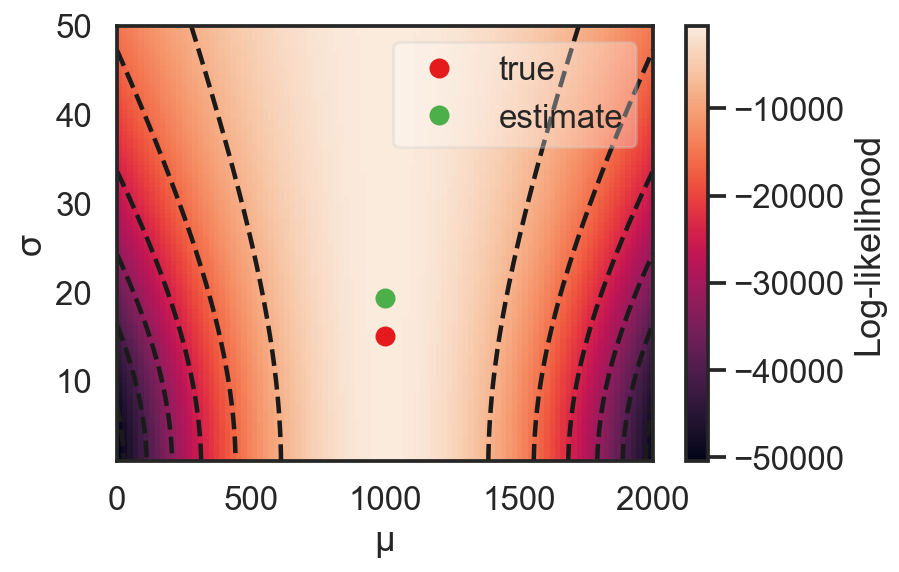

In [21]:
μ_range = np.linspace(0, 2000, 100)
σ_range = np.linspace(1, 50, 101)
ll = np.array([
    [log_likelihood((μ_, σ_), X) for μ_ in μ_range]
    for σ_ in σ_range
])

im = plt.pcolormesh(μ_range, σ_range, ll)
plt.contour(μ_range, σ_range, ll, colors='k')
plt.colorbar(im, label='Log-likelihood')
plt.plot(μ, σ, 'o', color=red, label='true')
plt.plot(μ_hat, σ_hat, 'o', color=green, label='estimate')
plt.xlabel('μ')
plt.ylabel('σ')
plt.legend(framealpha=0.3);

## Bootstrap

There are several analytic methods to quantify the uncertainty in the parameter estimations.

Instead, we will use the **bootstrap method**, in which we estimate the parameters from many resamples of the data.

> Bootstrapping is the practice of estimating properties of an estimator (such as its variance) by measuring those properties when sampling from an approximating distribution. One standard choice for an approximating distribution is the empirical distribution function of the observed data. In the case where a set of observations can be assumed to be from an independent and identically distributed population, this can be implemented by constructing a number of resamples with replacement, of the observed data set (and of equal size to the observed data set).

We parallelize this step for greater efficiency.

In [28]:
n_resamples = 1000
resamples = np.random.choice(X, size=(n_resamples, n))

In [29]:
from concurrent.futures import ThreadPoolExecutor

In [30]:
def max_log_likelihood(X):
    return scipy.optimize.fmin(
        func=neg_log_likelihood, 
        x0=θ_guess, 
        args=(X,),
        disp=0 # no prints
    )

with ThreadPoolExecutor() as exec:
    θ_bootstrap = list(exec.map(max_log_likelihood, resamples))

In [31]:
θ_bootstrap = np.array(θ_bootstrap)
μ_bootstrap, σ_bootstrap = θ_bootstrap.T

We can inspect the distributions of the estimations to see how far the true and estimated values are compared to all boostrap estimations.

We do this with a **corner plot** using the [corner](http://corner.readthedocs.io) package.

Here, the contours on the joint plot show standard deviations (of a gaussian) to demonstrate confidence regions.
This demonstrates that the truth is just on the edge of the confidence region.

In [35]:
from corner import corner

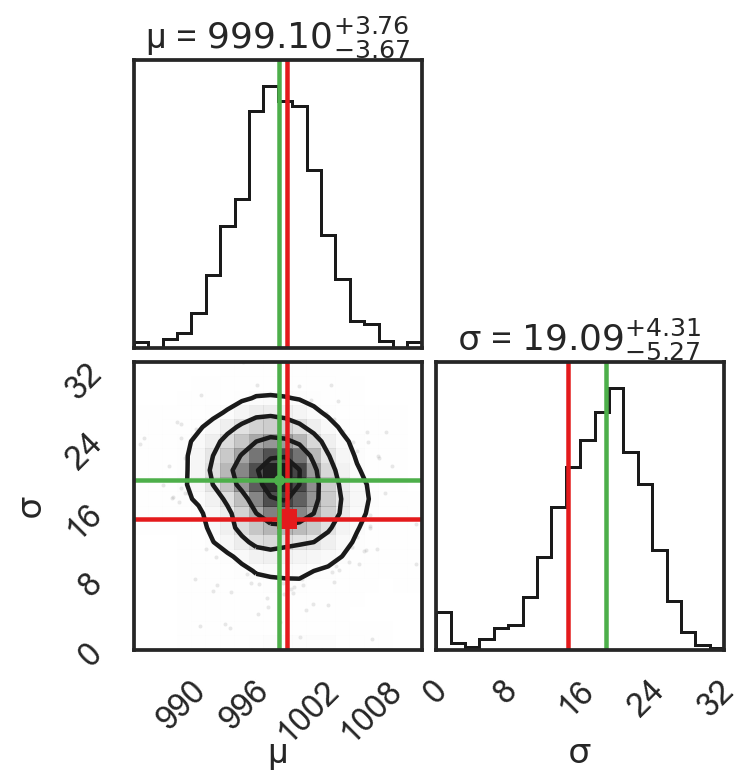

In [60]:
cor = corner(θ_bootstrap, 
    smooth=True,
    labels=['μ', 'σ'],
    truths=[μ, σ],
    truth_color=red,
    show_titles=True,
)
# add estimates
cor.axes[0].axvline(μ_hat, color=green)
cor.axes[3].axvline(σ_hat, color=green)
cor.axes[2].axvline(μ_hat, color=green)
cor.axes[2].axhline(σ_hat, color=green)
cor.axes[2].plot(μ_hat, σ_hat, '.', color=green);

# References

- Jake VanDerPlas's series of [blog posts on Bayesian inference](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/)
- [scipy.stats tutorial](http://docs.scipy.org/doc/scipy/reference/tutorial/stats.html)
- [Scipy's statistical functions](http://docs.scipy.org/doc/scipy/reference/stats.html)

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Scientific Computing with Python_](https://scicompy.yoavram.com/) course at IDC Herzliya.

The notebook was written using [Python](http://python.org/) 3.6.5.
Dependencies listed in [environment.yml](../environment.yml).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)